In [4]:
import torch
#torch.backends.cuda.matmul.allow_tf32 = False
import pickle
from common import logger, set_log
import networkx as nx
import random 
import numpy as np
from src.utils import cudavar
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
import os
from sklearn.metrics import average_precision_score
import src.graph_data_trainer as gdt
import time
import itertools
from src.earlystopping import EarlyStoppingModule
from sklearn.metrics import average_precision_score, ndcg_score, roc_auc_score
import tqdm
from GMN.configure import *
import scipy
from random import randrange
from pebble import ProcessPool
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import math

from src.hashing_main import * 
# from src.locality_sensitive_hashing_trained import LSH_tr
from src.locality_sensitive_hashing import *
def set_seed():
    # Set random seeds
  seed = 4
  random.seed(seed)
  np.random.seed(seed + 1)
  torch.manual_seed(seed + 2)
  torch.backends.cudnn.deterministic = False



In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
sns.set()
sns.set_style("white")

In [4]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import brewer2mpl
bmap = brewer2mpl.get_map('Set2', 'qualitative', 7)
color_list = bmap.mpl_colors
color_list = [(0.4, 0.7607843137254902, 0.6470588235294118),
             (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
             (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
             (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
             (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
             (1.0, 0.8509803921568627, 0.1843137254901961),
             (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
             (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

color_list = [(1, 0, 0),
             (0, 0, 1),
              (0,0,0),
             (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
             (0,0,0),
#              (0.4, 0.7607843137254902, 0.6470588235294118),
             (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
            (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),]

def latexify():
    matplotlib.rcParams['text.usetex'] = True
    matplotlib.rcParams['axes.spines.right'] = False
    matplotlib.rcParams['axes.spines.top'] = False
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    plt.rc('axes', linewidth=1)
    plt.rc('font', weight='bold')
    matplotlib.rc('text', usetex=True)
    matplotlib.rcParams['text.latex.preamble']=r"\usepackage{bm} \usepackage{amsmath,amsfonts} \boldmath"

latexify()


In [103]:
numIt=10000
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

av = Namespace(   want_cuda                    = False,
                  has_cuda                   = torch.cuda.is_available(),
                  MIN_QUERY_SUBGRAPH_SIZE    = 11,
                  MAX_QUERY_SUBGRAPH_SIZE    = 20,
                  MIN_CORPUS_SUBGRAPH_SIZE   = 16,
                  MAX_CORPUS_SUBGRAPH_SIZE   = 20,
                  no_of_query_subgraphs      = 300,
                  no_of_corpus_subgraphs     = 800,
                  num_hash_tables = 10, 
               subset_size = 8,
                  FEAT_TYPE                  = "One",
                  DIR_PATH                   =".",
                  DATASET_NAME               = "msweb294",
                  GMN_NPROPLAYERS            = 5,
                  MARGIN                     = 0.5,
                  SCALE =1,
                SPECIAL_FHASH = "",
               a = -100, b =100, 
               CsubQ = False,
               TASK="hinge", 
                HASH_MODE = "fhash",
               T=3,
               FMAP_SELECT = -1,
               pickle_fp = "",
               hcode_dim=64,
               embed_dim=10,
                  BATCH_SIZE                 =128*10000)


In [462]:
DotA = 2.4035930633544923e-06 #* 300
DotB = 0.034369468688964844 /300
CosA = 2.4755692481994628e-05 #*300
CosB = 0.012045621871948242 /300
AsymA = 1.8042588233947755e-05 #*300
AsymB = 0.054607391357421875 /300
WjacA = 1.2376856803894043e-05 #*300
WjacB = 0.015730857849121094 /300

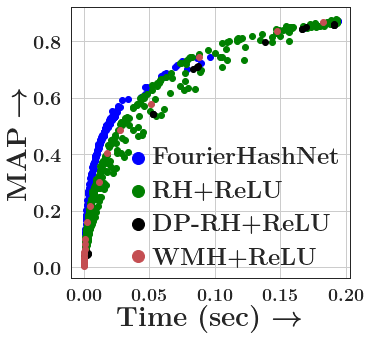

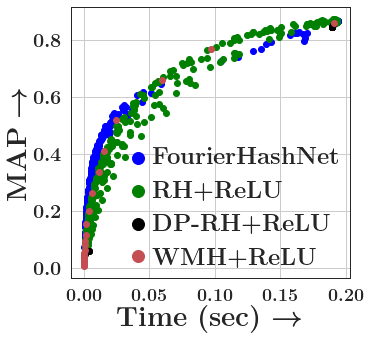

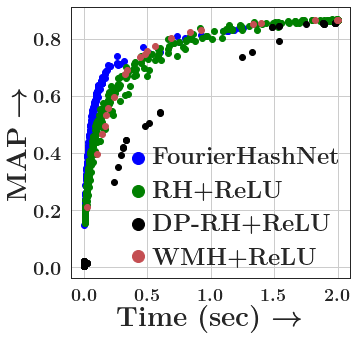

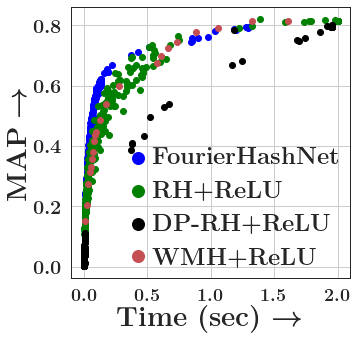

In [463]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{\scshape FourierHashNet}')  
    
    ax.scatter(AsymA*(np.array(all_data_enemycos[dname])[:,metric_dict_dec10[xmetric]])+CosB,\
                np.array(all_data_enemycos[dname])[:,metric_dict_dec10[metric]], color="Green",label=r'\textbf{RH+ReLU}')  
    ax.scatter(AsymA*(np.array(all_data_enemydot[dname])[:,metric_dict_dec10[xmetric]])+DotB,\
                np.array(all_data_enemydot[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{DP-RH+ReLU}')  

    idx = np.argsort(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]])
    ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                        np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[metric]][idx],\
                 'o',c="r",linewidth=3,label=r'\textbf{WMH+ReLU}')    
    
    
    ax.legend(prop={'size': 24}, frameon=False,markerscale=2,handletextpad=-0.4,borderaxespad=0)

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
    
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     
        

    plt.savefig(f"./FinalFigsLatex/{dname}_trained_Ablation_Time.pdf", bbox_inches='tight')
  

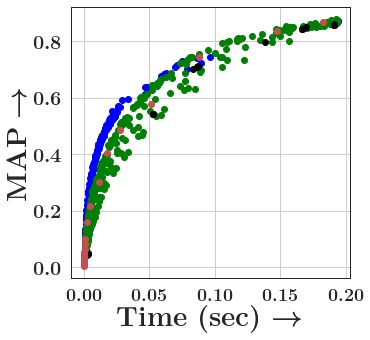

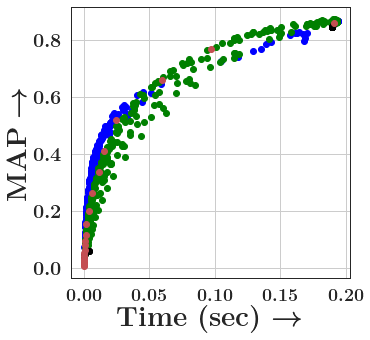

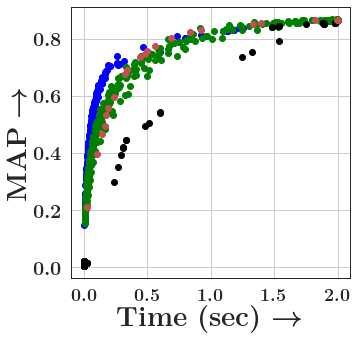

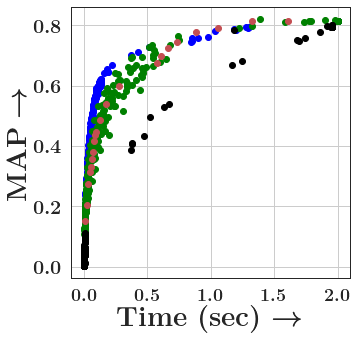

In [464]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    
    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{\scshape FourierHashNet}')  
    ax.scatter(AsymA*(np.array(all_data_enemycos[dname])[:,metric_dict_dec10[xmetric]])+CosB,\
                np.array(all_data_enemycos[dname])[:,metric_dict_dec10[metric]], color="Green",label=r'\textbf{RH+ReLU}')  
    ax.scatter(AsymA*(np.array(all_data_enemydot[dname])[:,metric_dict_dec10[xmetric]])+DotB,\
                np.array(all_data_enemydot[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{DP-RH+ReLU}')  


    idx = np.argsort(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]])
    ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                        np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[metric]][idx],\
                 'o',c="r",linewidth=3,label=r'\textbf{WMH+ReLU}')    
    
    

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
      
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     
        
    plt.savefig(f"./FinalFigsLatex/{dname}_trained_Ablation_Time_wolegend.pdf", bbox_inches='tight')


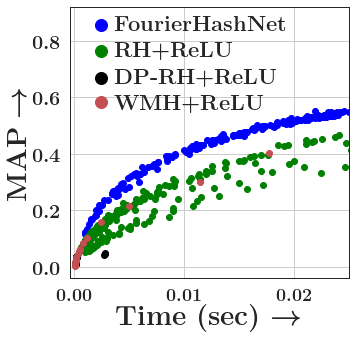

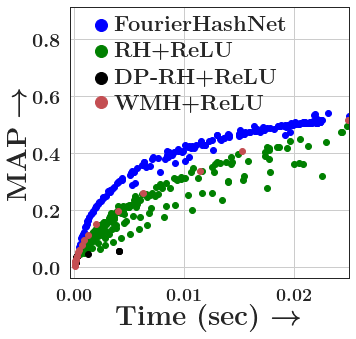

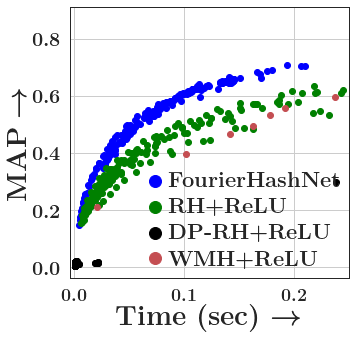

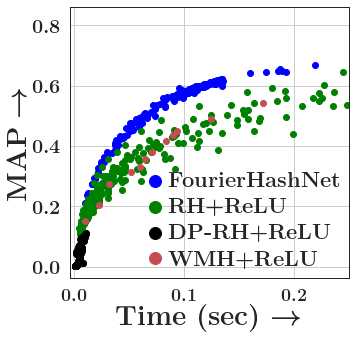

In [474]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    
    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{\textsc{ FourierHashNet}}')  
    ax.scatter(AsymA*(np.array(all_data_enemycos[dname])[:,metric_dict_dec10[xmetric]])+CosB,\
                np.array(all_data_enemycos[dname])[:,metric_dict_dec10[metric]], color="Green",label=r'\textbf{RH+ReLU}')  
    ax.scatter(AsymA*(np.array(all_data_enemydot[dname])[:,metric_dict_dec10[xmetric]])+DotB,\
                np.array(all_data_enemydot[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{DP-RH+ReLU}')  


    idx = np.argsort(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]])
    ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                        np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[metric]][idx],\
                 'o',c="r",linewidth=3,label=r'\textbf{WMH+ReLU}')    
    
    
    ax.legend(prop={'size': 22}, frameon=False,markerscale=2,handletextpad=-0.4,borderaxespad=0,labelspacing=0.3)

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=0.1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=0.1)
    ax.set_xscale('linear')
        
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     

    if dname in ["msweb294","msweb294_1"]:
        ax.set_xlim(ax.get_xticks()[1]/10-0.1/300,ax.get_xticks()[-1]/10)
    else:
        ax.set_xlim(ax.get_xticks()[1]/10-1/300,ax.get_xticks()[-1]/10)
    
    plt.savefig(f"./FinalFigsLatex/{dname}_trained_Ablation_Time_top20pct.pdf", bbox_inches='tight')

   

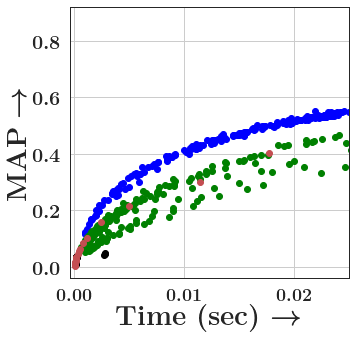

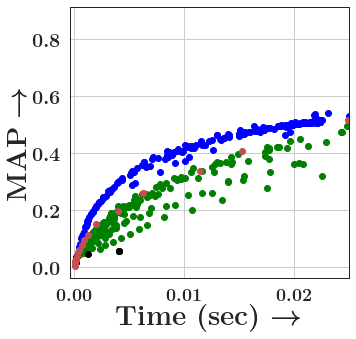

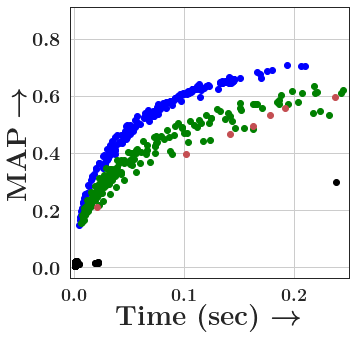

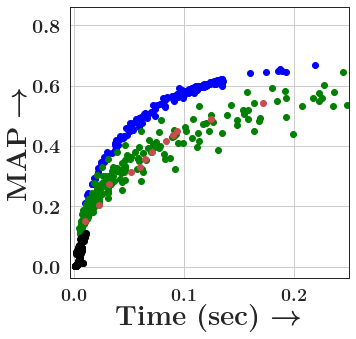

In [475]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    
    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{\scshape FourierHashNet}')  
    ax.scatter(AsymA*(np.array(all_data_enemycos[dname])[:,metric_dict_dec10[xmetric]])+CosB,\
                np.array(all_data_enemycos[dname])[:,metric_dict_dec10[metric]], color="Green",label=r'\textbf{RH+ReLU}')  
    ax.scatter(AsymA*(np.array(all_data_enemydot[dname])[:,metric_dict_dec10[xmetric]])+DotB,\
                np.array(all_data_enemydot[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{DP-RH+ReLU}')  


    idx = np.argsort(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]])
    ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                        np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[metric]][idx],\
                 'o',c="r",linewidth=3,label=r'\textbf{WMH+ReLU}')    
    
    

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=0.1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=0.1)
    ax.set_xscale('linear')

    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     

    if dname in ["msweb294","msweb294_1"]:
        ax.set_xlim(ax.get_xticks()[1]/10-0.1/300,ax.get_xticks()[-1]/10)
    else:
        ax.set_xlim(ax.get_xticks()[1]/10-1/300,ax.get_xticks()[-1]/10)
    
    plt.savefig(f"./FinalFigsLatex/{dname}_trained_Ablation_Time_top20pct_wolegend.pdf", bbox_inches='tight')
  

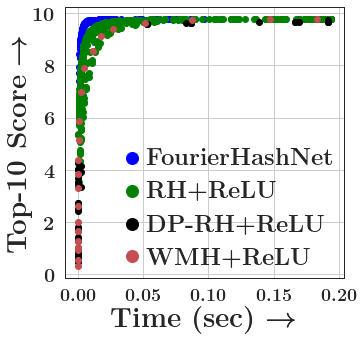

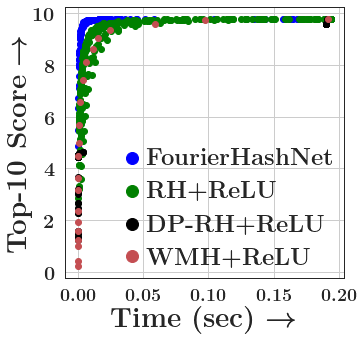

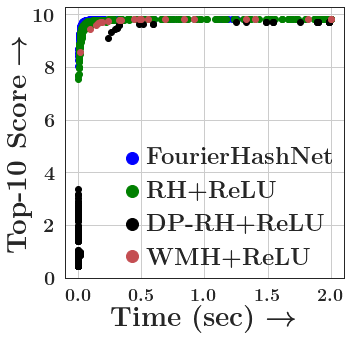

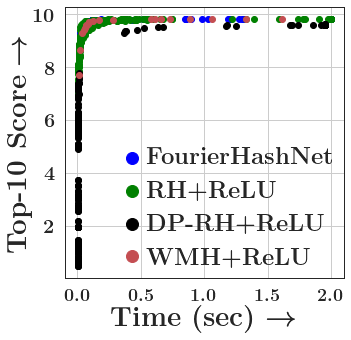

In [467]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
# metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    
    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{\scshape FourierHashNet}')  
    ax.scatter(AsymA*(np.array(all_data_enemycos[dname])[:,metric_dict_dec10[xmetric]])+CosB,\
                np.array(all_data_enemycos[dname])[:,metric_dict_dec10[metric]], color="Green",label=r'\textbf{RH+ReLU}')  
    ax.scatter(AsymA*(np.array(all_data_enemydot[dname])[:,metric_dict_dec10[xmetric]])+DotB,\
                np.array(all_data_enemydot[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{DP-RH+ReLU}')  

    idx = np.argsort(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]])
    ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                        np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[metric]][idx],\
                 'o',c="r",linewidth=3,label=r'\textbf{WMH+ReLU}')    
    
    
    ax.legend(prop={'size': 24}, frameon=False,markerscale=2,handletextpad=-0.4,borderaxespad=0)

    ax.set_ylabel(r'\textbf{Top-10 Score} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
    
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     

    plt.savefig(f"./FinalFigsLatex/{dname}_trained_Ablation_Time_topK.pdf", bbox_inches='tight')


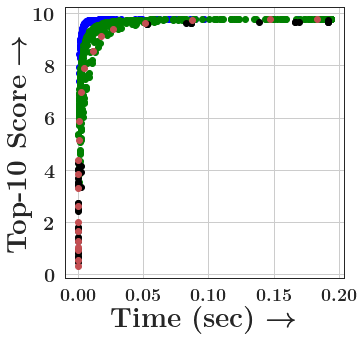

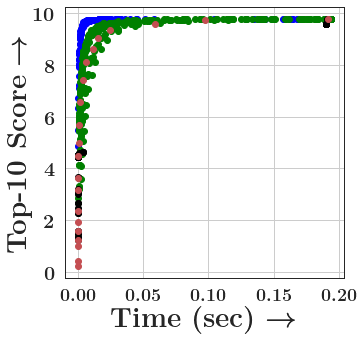

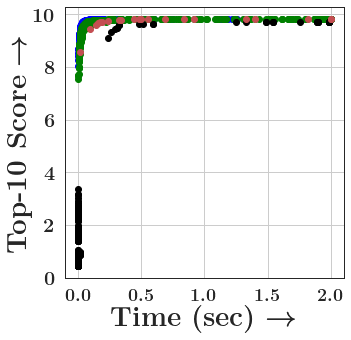

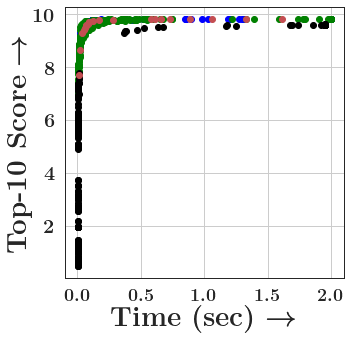

In [468]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
# metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    
    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{\scshape FourierHashNet}')  
    ax.scatter(AsymA*(np.array(all_data_enemycos[dname])[:,metric_dict_dec10[xmetric]])+CosB,\
                np.array(all_data_enemycos[dname])[:,metric_dict_dec10[metric]], color="Green",label=r'\textbf{RH+ReLU}')  
    ax.scatter(AsymA*(np.array(all_data_enemydot[dname])[:,metric_dict_dec10[xmetric]])+DotB,\
                np.array(all_data_enemydot[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{DP-RH+ReLU}')  

    idx = np.argsort(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]])
    ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                        np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[metric]][idx],\
                 'o',c="r",linewidth=3,label=r'\textbf{WMH+ReLU}')    
    
    

    ax.set_ylabel(r'\textbf{Top-10 Score} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
        
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     

    plt.savefig(f"./FinalFigsLatex/{dname}_trained_Ablation_Time_topK_wolegend.pdf", bbox_inches='tight')



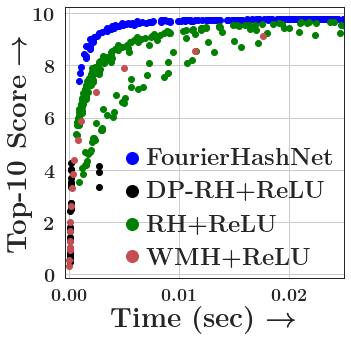

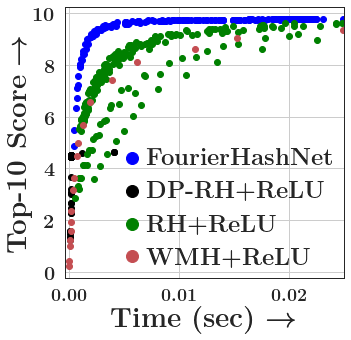

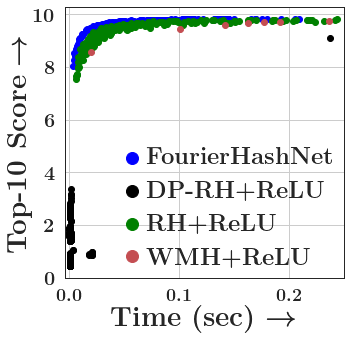

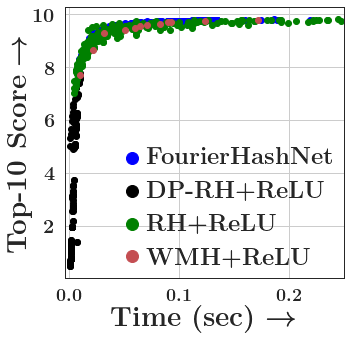

In [476]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
# metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{\scshape FourierHashNet}')      
    ax.scatter(AsymA*(np.array(all_data_enemydot[dname])[:,metric_dict_dec10[xmetric]])+DotB,\
                np.array(all_data_enemydot[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{DP-RH+ReLU}')  
    ax.scatter(AsymA*(np.array(all_data_enemycos[dname])[:,metric_dict_dec10[xmetric]])+CosB,\
                np.array(all_data_enemycos[dname])[:,metric_dict_dec10[metric]], color="Green",label=r'\textbf{RH+ReLU}')  


    idx = np.argsort(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]])
    ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                        np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[metric]][idx],\
                 'o',c="r",linewidth=3,label=r'\textbf{WMH+ReLU}')    
    
    
    ax.legend(prop={'size': 24}, frameon=False,markerscale=2,handletextpad=-0.4,borderaxespad=0)

    ax.set_ylabel(r'\textbf{Top-10 Score} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
       
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    if dname in ["msweb294","msweb294_1"]:
        ax.set_xlim(ax.get_xticks()[1]/10-0.1/300,ax.get_xticks()[-1]/10)
    else:
        ax.set_xlim(ax.get_xticks()[1]/10-1/300,ax.get_xticks()[-1]/10)
         
    plt.savefig(f"./FinalFigsLatex/{dname}_trained_Ablation_Time_top10pct_topK.pdf", bbox_inches='tight')
 

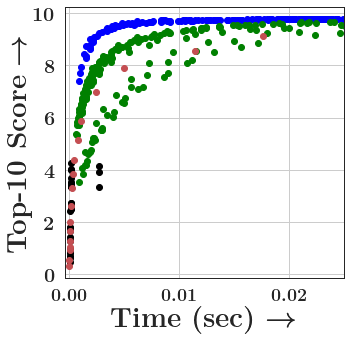

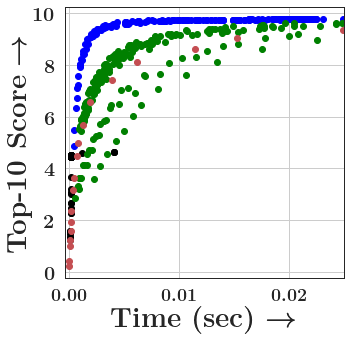

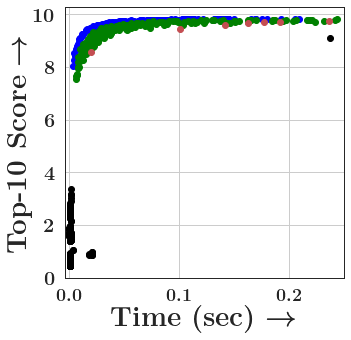

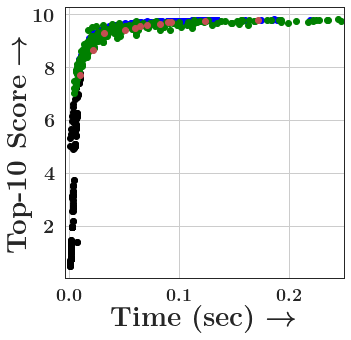

In [477]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
# metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{\scshape FourierHashNet}')      
    ax.scatter(AsymA*(np.array(all_data_enemydot[dname])[:,metric_dict_dec10[xmetric]])+DotB,\
                np.array(all_data_enemydot[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{DP-RH+ReLU}')  
    ax.scatter(AsymA*(np.array(all_data_enemycos[dname])[:,metric_dict_dec10[xmetric]])+CosB,\
                np.array(all_data_enemycos[dname])[:,metric_dict_dec10[metric]], color="Green",label=r'\textbf{RH+ReLU}')  


    idx = np.argsort(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]])
    ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                        np.array(all_untrained_enemyWmh[dname]["chum"])[:,metric_dict_dec10[metric]][idx],\
                 'o',c="r",linewidth=3,label=r'\textbf{WMH+ReLU}')    
    
    

    ax.set_ylabel(r'\textbf{Top-10 Score} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
        
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    if dname in ["msweb294","msweb294_1"]:
        ax.set_xlim(ax.get_xticks()[1]/10-0.1/300,ax.get_xticks()[-1]/10)
    else:
        ax.set_xlim(ax.get_xticks()[1]/10-1/300,ax.get_xticks()[-1]/10)
         
    plt.savefig(f"./FinalFigsLatex/{dname}_trained_Ablation_Time_top10pct_topK_wolegend.pdf", bbox_inches='tight')
           

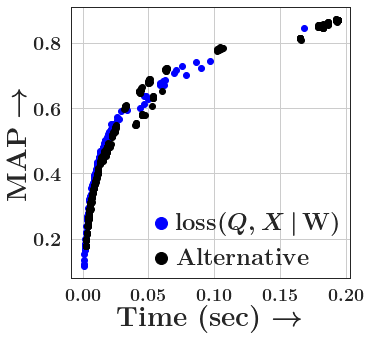

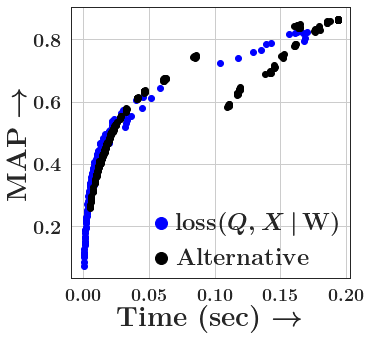

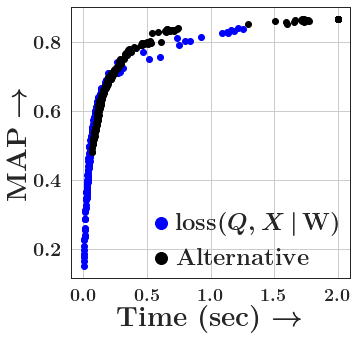

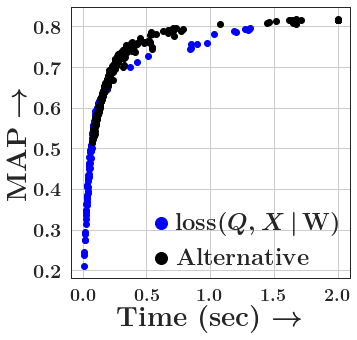

In [471]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_our_bce3_pgnn = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3_pgnn[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_permgnn_loss8BCE3muse10.pkl","rb"))
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
     
  
metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt



for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    total_len = len(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])
    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{$\text{loss}(Q,X\,|\, \textbf{W})$')  
    ax.scatter(AsymA*(np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{Alternative}')  

    
    
    ax.legend(prop={'size': 24}, frameon=False,markerscale=2,handletextpad=-0.4,borderaxespad=0)

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
      
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     
        

    plt.savefig(f"./FinalFigsLatex/{dname}_trained_HashcodeAblation_Time_Full.pdf", bbox_inches='tight')
  

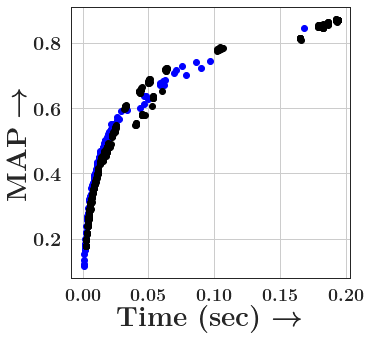

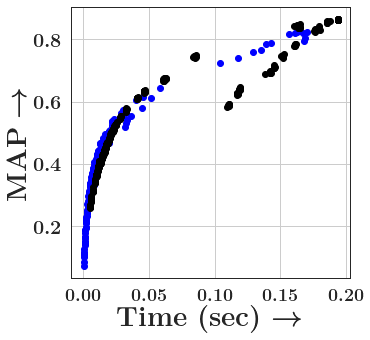

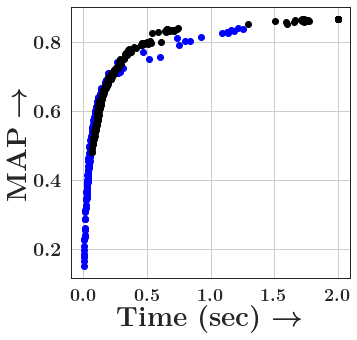

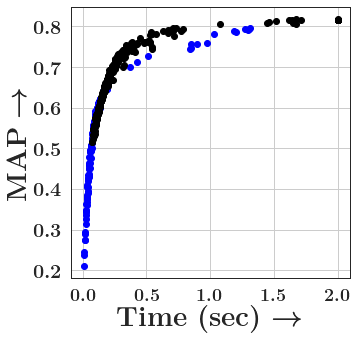

In [472]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_our_bce3_pgnn = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3_pgnn[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_permgnn_loss8BCE3muse10.pkl","rb"))
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
     
  
metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt



for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    total_len = len(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])
    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{$\text{loss}(Q,X\,|\, \textbf{W})$')  
    ax.scatter(AsymA*(np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{Alternative}')  

    
    

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
       
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     
    plt.savefig(f"./FinalFigsLatex/{dname}_trained_HashcodeAblation_Time_Full_wolegend.pdf", bbox_inches='tight')
 

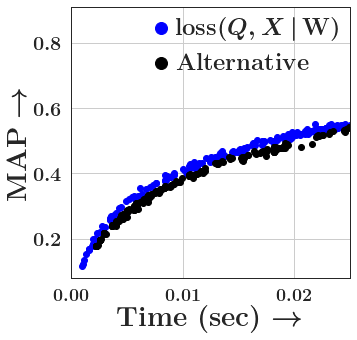

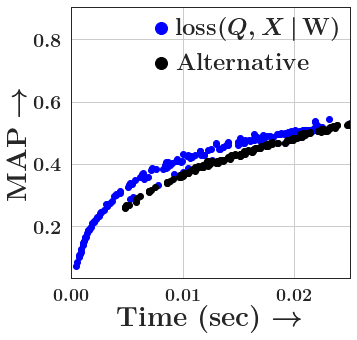

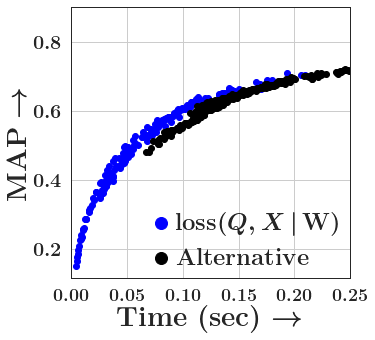

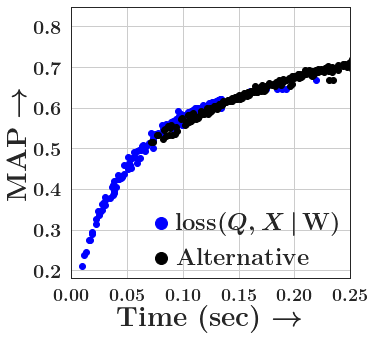

In [480]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_our_bce3_pgnn = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3_pgnn[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_permgnn_loss8BCE3muse10.pkl","rb"))
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
     
  
metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt



for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{$\text{loss}(Q,X\,|\, \textbf{W})$')  
    ax.scatter(AsymA*(np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{Alternative}')  

    
    ax.legend(prop={'size': 24}, frameon=False,markerscale=2,handletextpad=-0.4,borderaxespad=0)

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
      
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     

    ax.set_xlim(ax.get_xticks()[1]/10,ax.get_xticks()[-1]/10)

    plt.savefig(f"./FinalFigsLatex/{dname}_trained_HashcodeAblation_Time_top20pct.pdf", bbox_inches='tight')


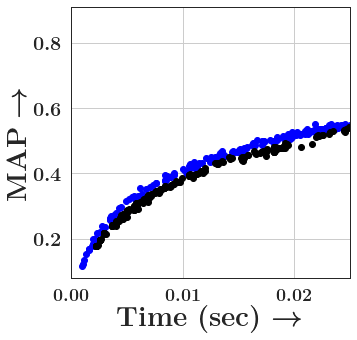

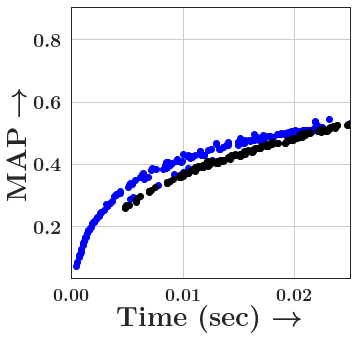

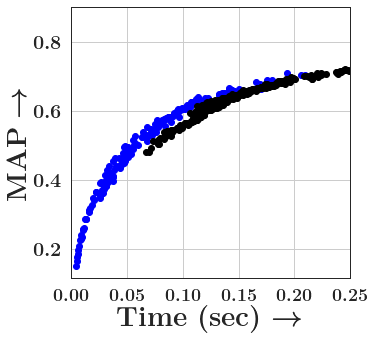

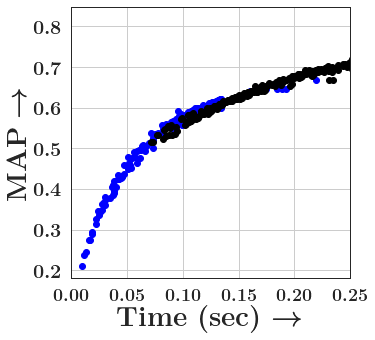

In [481]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_our_bce3_pgnn = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3_pgnn[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_permgnn_loss8BCE3muse10.pkl","rb"))
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
     
  
metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt



for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{$\text{loss}(Q,X\,|\, \textbf{W})$')  
    ax.scatter(AsymA*(np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{Alternative}')  

    

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
        
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     
        
    ax.set_xlim(ax.get_xticks()[1]/10,ax.get_xticks()[-1]/10)
    plt.savefig(f"./FinalFigsLatex/{dname}_trained_HashcodeAblation_Time_top20pct_wolegend.pdf", bbox_inches='tight')

# plt.show()    

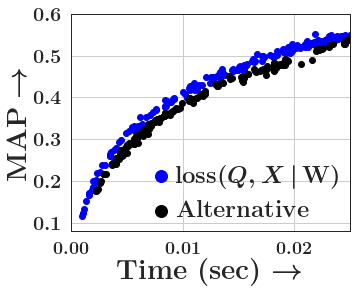

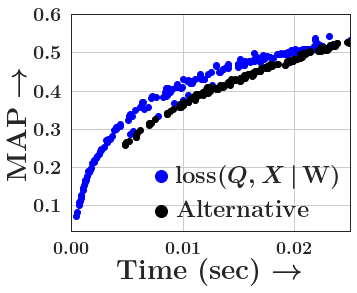

In [511]:
datasets = ["msweb294","msweb294_1"]
all_data_our_bce3 = {}
all_data_our_bce3_pgnn = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3_pgnn[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_permgnn_loss8BCE3muse10.pkl","rb"))
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
     
  
metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt



for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*4))

    dname  = datasets[idx1]

    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{$\text{loss}(Q,X\,|\, \textbf{W})$')  
    ax.scatter(AsymA*(np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{Alternative}')  

    
    ax.legend(prop={'size': 24}, frameon=False,markerscale=2,handletextpad=-0.4,borderaxespad=0)

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
       
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     

    ax.set_xlim(ax.get_xticks()[1]/10,ax.get_xticks()[-1]/10)
    ax.set_ylim(top=0.6)

    plt.savefig(f"./FinalFigsLatex/{dname}_trained_HashcodeAblation_Time_top20pct_rect.pdf", bbox_inches='tight')



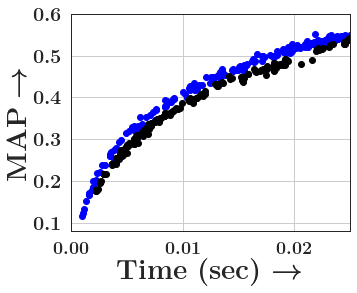

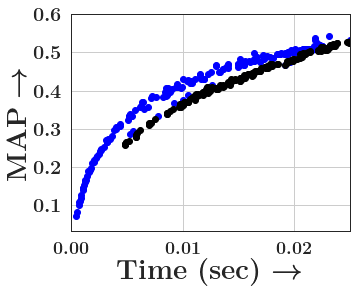

In [510]:
datasets = ["msweb294","msweb294_1"]
all_data_our_bce3 = {}
all_data_our_bce3_pgnn = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3_pgnn[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_permgnn_loss8BCE3muse10.pkl","rb"))
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
     
  
metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt



for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*4))

    dname  = datasets[idx1]

    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{$\text{loss}(Q,X\,|\, \textbf{W})$')  
    ax.scatter(AsymA*(np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{Alternative}')  

    

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
        
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     

    ax.set_xlim(ax.get_xticks()[1]/10,ax.get_xticks()[-1]/10)
    ax.set_ylim(top=0.6)

    plt.savefig(f"./FinalFigsLatex/{dname}_trained_HashcodeAblation_Time_top20pct_wolegend_rect.pdf", bbox_inches='tight')


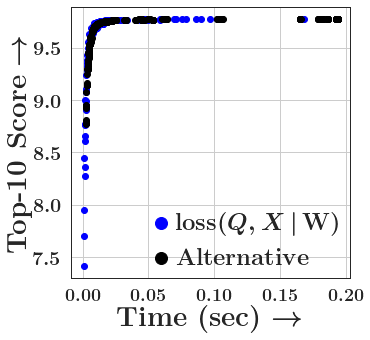

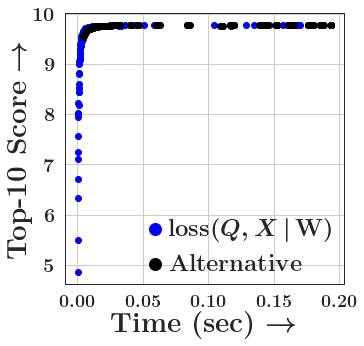

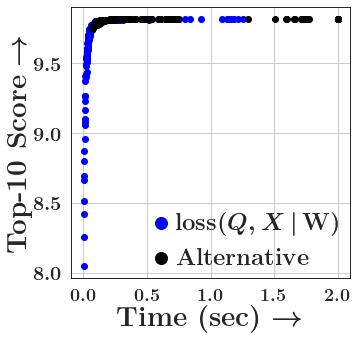

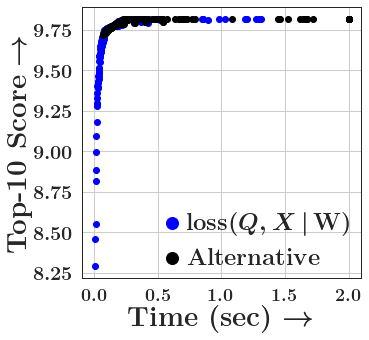

In [482]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_our_bce3_pgnn = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3_pgnn[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_permgnn_loss8BCE3muse10.pkl","rb"))
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
     
  
metric= "topKscore_10"
# metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt



for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    total_len = len(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])
    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{$\text{loss}(Q,X\,|\, \textbf{W})$')  
    ax.scatter(AsymA*(np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{Alternative}')  

    
    
    ax.legend(prop={'size': 24}, frameon=False,markerscale=2,handletextpad=-0.4,borderaxespad=0)

    ax.set_ylabel(r'\textbf{Top-10 Score} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
        
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     

    plt.savefig(f"./FinalFigsLatex/{dname}_trained_HashcodeAblation_Time_topK_Full.pdf", bbox_inches='tight')
  

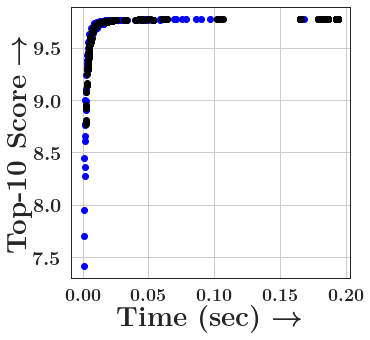

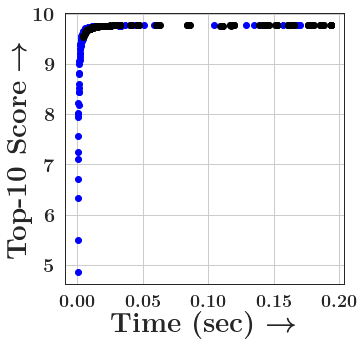

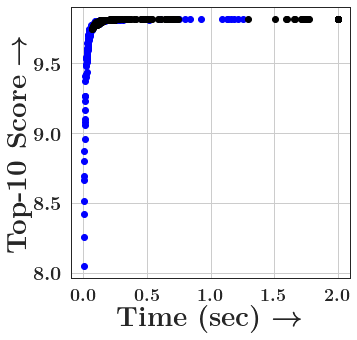

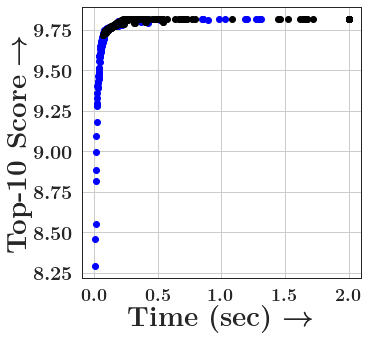

In [483]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_our_bce3_pgnn = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3_pgnn[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_permgnn_loss8BCE3muse10.pkl","rb"))
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
     
  
metric= "topKscore_10"
# metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt



for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    total_len = len(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])
    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{$\text{loss}(Q,X\,|\, \textbf{W})$')  
    ax.scatter(AsymA*(np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{Alternative}')  

    
    ax.set_ylabel(r'\textbf{Top-10 Score} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
         
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     
        

    plt.savefig(f"./FinalFigsLatex/{dname}_trained_HashcodeAblation_Time_topK_Full_wolegend.pdf", bbox_inches='tight')
 

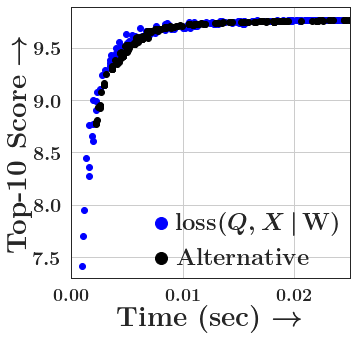

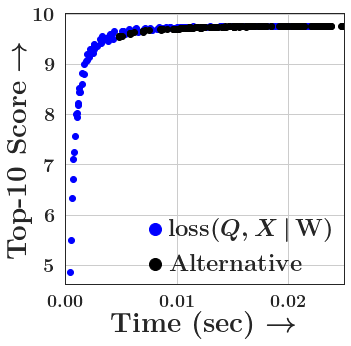

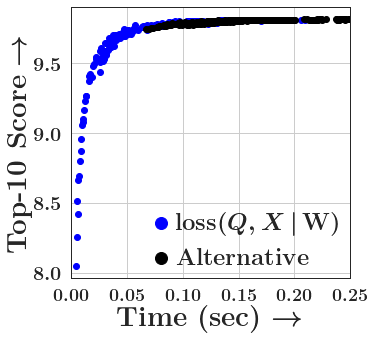

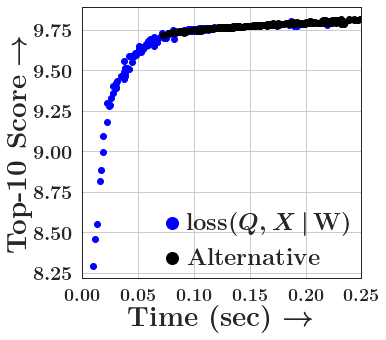

In [484]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_our_bce3_pgnn = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3_pgnn[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_permgnn_loss8BCE3muse10.pkl","rb"))
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
     
  
metric= "topKscore_10"
# metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt



for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{$\text{loss}(Q,X\,|\, \textbf{W})$')  
    ax.scatter(AsymA*(np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{Alternative}')  

    
    ax.legend(prop={'size': 24}, frameon=False,markerscale=2,handletextpad=-0.4,borderaxespad=0)

    ax.set_ylabel(r'\textbf{Top-10 Score} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
      
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     
        

    ax.set_xlim(ax.get_xticks()[1]/10,ax.get_xticks()[-1]/10)
    plt.savefig(f"./FinalFigsLatex/{dname}_trained_HashcodeAblation_Time_topK_top20pct.pdf", bbox_inches='tight')



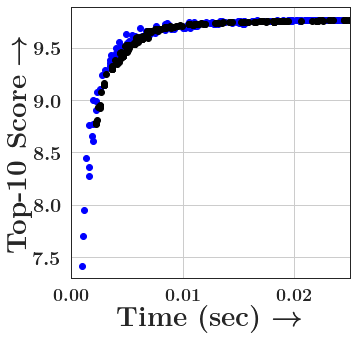

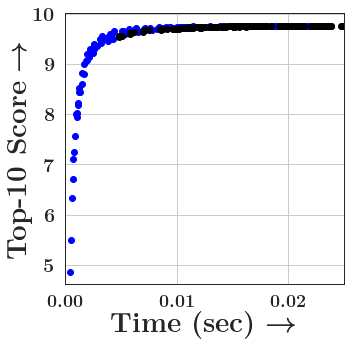

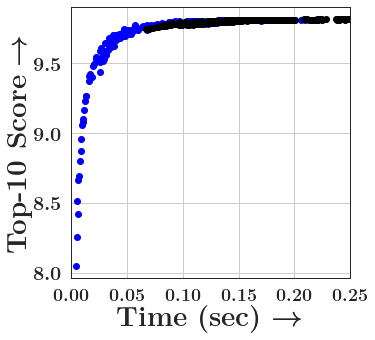

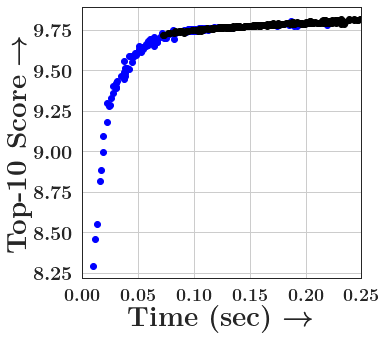

In [485]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
all_data_our_bce3 = {}
all_data_our_bce3_pgnn = {}
all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_enemyWmh = {}


for dname in datasets: 
    all_data_our_bce3_pgnn[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_permgnn_loss8BCE3muse10.pkl","rb"))
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
     
  
metric= "topKscore_10"
# metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt



for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{$\text{loss}(Q,X\,|\, \textbf{W})$')  
    ax.scatter(AsymA*(np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_pgnn[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{Alternative}')  

    

    ax.set_ylabel(r'\textbf{Top-10 Score} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
      
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     

    ax.set_xlim(ax.get_xticks()[1]/10,ax.get_xticks()[-1]/10)
    plt.savefig(f"./FinalFigsLatex/{dname}_trained_HashcodeAblation_Time_topK_top20pct_wolegend.pdf", bbox_inches='tight')


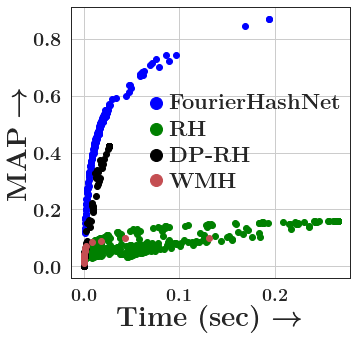

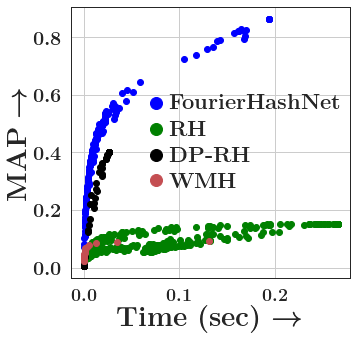

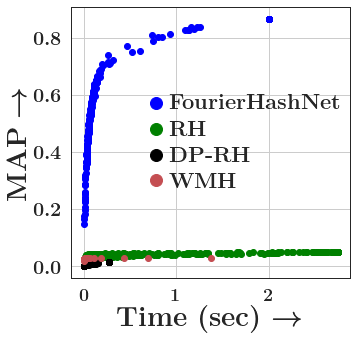

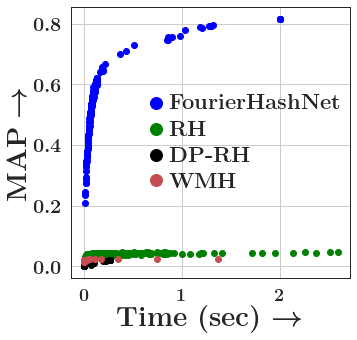

In [486]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
# datasets = ["msweb294"]
all_data_our_bce3 = {}
all_data_normalcos = {}
all_data_normaldot = {} 

all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_normalCos = {}
all_untrained_normalDot = {}
all_untrained_enemyWmh = {}
all_untrained_normalWmh = {}


for dname in datasets: 
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_normalcos[dname] = pickle.load(open(f"./parallelDumps/{dname}_cos_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_normaldot[dname] = pickle.load(open(f"./parallelDumps/{dname}_dot_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    all_untrained_normalWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_wjac_untrained_wmh","rb"))
    

metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{\scshape FourierHashNet}')  
    ax.scatter(CosA*(np.array(all_data_normalcos[dname])[:,metric_dict_dec10[xmetric]])+CosB,\
                np.array(all_data_normalcos[dname])[:,metric_dict_dec10[metric]], color="Green",label=r'\textbf{RH}')  
    ax.scatter(DotA*(np.array(all_data_normaldot[dname])[:,metric_dict_dec10[xmetric]])+DotB,\
                np.array(all_data_normaldot[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{DP-RH}')  
    idx = np.argsort(np.array(all_untrained_normalWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]])
    ax.plot(WjacA*(np.array(all_untrained_normalWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                        np.array(all_untrained_normalWmh[dname]["chum"])[:,metric_dict_dec10[metric]][idx],\
                 'o',c="r",linewidth=3,label=r'\textbf{WMH}')    
    

    
    ax.legend(prop={'size': 22}, frameon=False,markerscale=2,handletextpad=-0.4,borderaxespad=0,labelspacing=0.3)

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
      
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     
        

    plt.savefig(f"./FinalFigsLatex/{dname}_trained_Normal_Time_full.pdf", bbox_inches='tight')



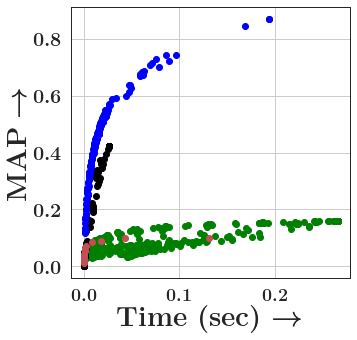

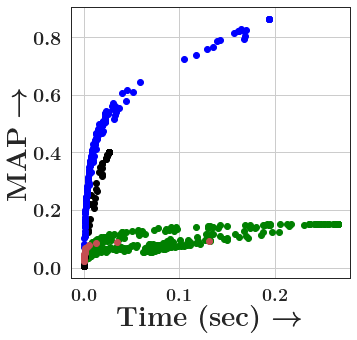

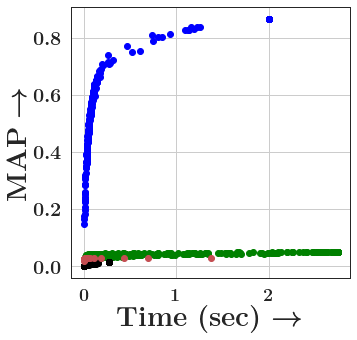

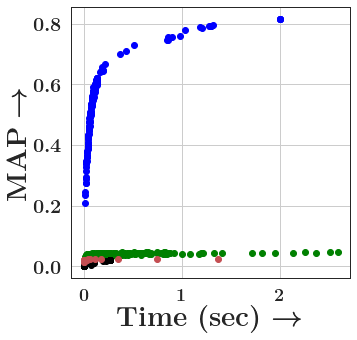

In [487]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
# datasets = ["msweb294"]
all_data_our_bce3 = {}
all_data_normalcos = {}
all_data_normaldot = {} 

all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_normalCos = {}
all_untrained_normalDot = {}
all_untrained_enemyWmh = {}
all_untrained_normalWmh = {}


for dname in datasets: 
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_normalcos[dname] = pickle.load(open(f"./parallelDumps/{dname}_cos_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_normaldot[dname] = pickle.load(open(f"./parallelDumps/{dname}_dot_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    all_untrained_normalWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_wjac_untrained_wmh","rb"))
    

metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    ax.scatter(CosA*(np.array(all_data_normalcos[dname])[:,metric_dict_dec10[xmetric]])+CosB,\
                np.array(all_data_normalcos[dname])[:,metric_dict_dec10[metric]], color="Green",label=r'\textbf{RH}')  
    ax.scatter(DotA*(np.array(all_data_normaldot[dname])[:,metric_dict_dec10[xmetric]])+DotB,\
                np.array(all_data_normaldot[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{DP-RH}')  
    idx = np.argsort(np.array(all_untrained_normalWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]])
    ax.plot(WjacA*(np.array(all_untrained_normalWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                        np.array(all_untrained_normalWmh[dname]["chum"])[:,metric_dict_dec10[metric]][idx],\
                 'o',c="r",linewidth=3,label=r'\textbf{WMH}')    
    
    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{\scshape FourierHashNet}')  
 
    

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
       
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     
    plt.savefig(f"./FinalFigsLatex/{dname}_trained_Normal_Time_full_wolegend.pdf", bbox_inches='tight')


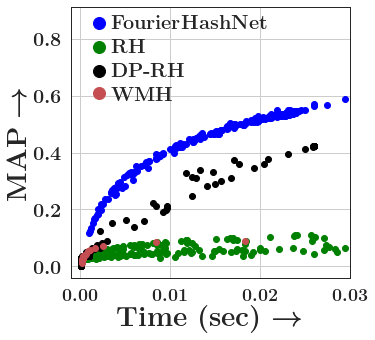

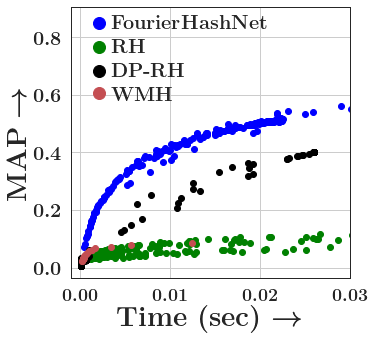

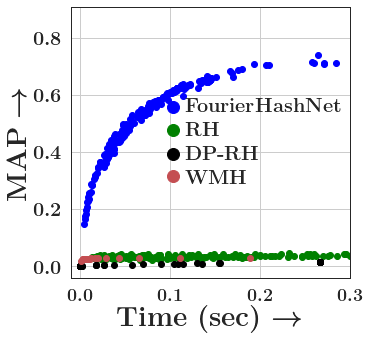

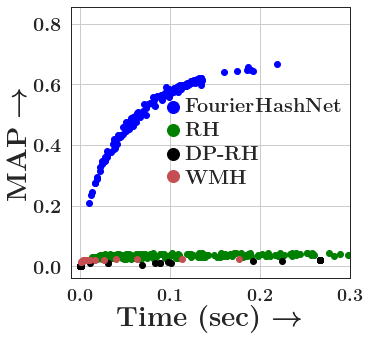

In [488]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
# datasets = ["msweb294"]
all_data_our_bce3 = {}
all_data_normalcos = {}
all_data_normaldot = {} 

all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_normalCos = {}
all_untrained_normalDot = {}
all_untrained_enemyWmh = {}
all_untrained_normalWmh = {}


for dname in datasets: 
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_normalcos[dname] = pickle.load(open(f"./parallelDumps/{dname}_cos_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_normaldot[dname] = pickle.load(open(f"./parallelDumps/{dname}_dot_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    all_untrained_normalWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_wjac_untrained_wmh","rb"))
    

metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt

for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{\scshape FourierHashNet}')  
 
    ax.scatter(CosA*(np.array(all_data_normalcos[dname])[:,metric_dict_dec10[xmetric]])+CosB,\
                np.array(all_data_normalcos[dname])[:,metric_dict_dec10[metric]], color="Green",label=r'\textbf{RH}')  
    ax.scatter(DotA*(np.array(all_data_normaldot[dname])[:,metric_dict_dec10[xmetric]])+DotB,\
                np.array(all_data_normaldot[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{DP-RH}')  
    idx = np.argsort(np.array(all_untrained_normalWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]])
    ax.plot(WjacA*(np.array(all_untrained_normalWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                        np.array(all_untrained_normalWmh[dname]["chum"])[:,metric_dict_dec10[metric]][idx],\
                 'o',c="r",linewidth=3,label=r'\textbf{WMH}')    
    

    
    ax.legend(prop={'size': 20}, frameon=False,markerscale=2,handletextpad=-0.4,borderaxespad=0,labelspacing=0.3)

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
        
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     
        
    if dname in ["msweb294","msweb294_1"]:
        ax.set_xlim(ax.get_xticks()[1]/10-0.3/300,ax.get_xticks()[-1]/10)
    else:
        ax.set_xlim(ax.get_xticks()[1]/10-3/300,ax.get_xticks()[-1]/10)
    plt.savefig(f"./FinalFigsLatex/{dname}_trained_Normal_Time_top10pct.pdf", bbox_inches='tight')



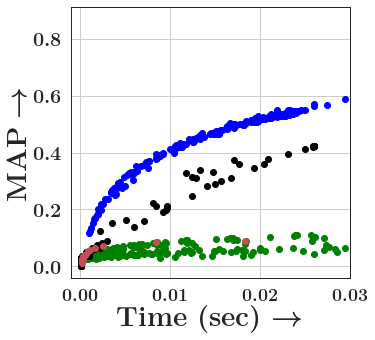

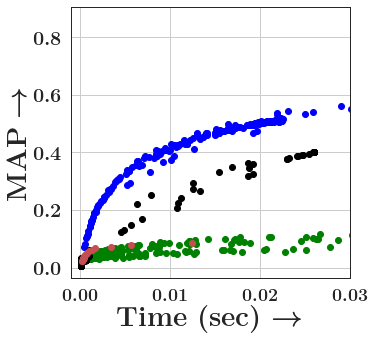

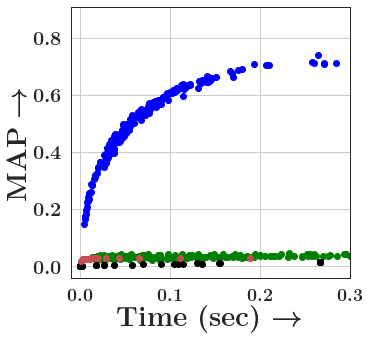

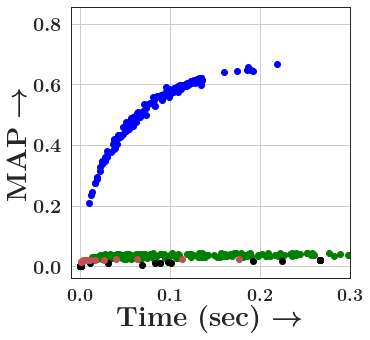

In [489]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]
# datasets = ["msweb294"]
all_data_our_bce3 = {}
all_data_normalcos = {}
all_data_normaldot = {} 

all_data_enemycos = {}
all_data_enemydot = {} 
all_untrained_fhash = {}
all_untrained_enemyCos = {}
all_untrained_enemyDot = {}
all_untrained_normalCos = {}
all_untrained_normalDot = {}
all_untrained_enemyWmh = {}
all_untrained_normalWmh = {}


for dname in datasets: 
    all_data_our_bce3[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_normalcos[dname] = pickle.load(open(f"./parallelDumps/{dname}_cos_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_normaldot[dname] = pickle.load(open(f"./parallelDumps/{dname}_dot_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemycos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyCos_sc_loss_hingeemb8.pkl","rb"))
    all_data_enemydot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_EnemyDot_sc_loss_hingeemb8.pkl","rb"))
    all_untrained_fhash[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_fhash","rb"))
    all_untrained_enemyCos[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_cosine","rb"))
    all_untrained_enemyDot[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_dot","rb"))
    all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    all_untrained_normalWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_wjac_untrained_wmh","rb"))
    

metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    ax.scatter(AsymA*(np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{\scshape FourierHashNet}')  
    ax.scatter(CosA*(np.array(all_data_normalcos[dname])[:,metric_dict_dec10[xmetric]])+CosB,\
                np.array(all_data_normalcos[dname])[:,metric_dict_dec10[metric]], color="Green",label=r'\textbf{RH}')  
    ax.scatter(DotA*(np.array(all_data_normaldot[dname])[:,metric_dict_dec10[xmetric]])+DotB,\
                np.array(all_data_normaldot[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{DP-RH}')  
    idx = np.argsort(np.array(all_untrained_normalWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]])
    ax.plot(WjacA*(np.array(all_untrained_normalWmh[dname]["chum"])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                        np.array(all_untrained_normalWmh[dname]["chum"])[:,metric_dict_dec10[metric]][idx],\
                 'o',c="r",linewidth=3,label=r'\textbf{WMH}')    
    

    

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
       
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     
        
    if dname in ["msweb294","msweb294_1"]:
        ax.set_xlim(ax.get_xticks()[1]/10-0.3/300,ax.get_xticks()[-1]/10)
    else:
        ax.set_xlim(ax.get_xticks()[1]/10-3/300,ax.get_xticks()[-1]/10)
    plt.savefig(f"./FinalFigsLatex/{dname}_trained_Normal_Time_top10pct_wolegend.pdf", bbox_inches='tight')



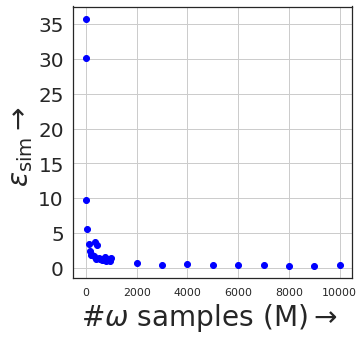

In [10]:
all_data_wvar = pickle.load(open("./parallelDumps/FinalFigFmapVerify.pkl","rb"))
xvals = []
yvals = []
for m in [1,5,10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
       650, 700, 750, 800, 850, 900, 950, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]:
#     yvals.append(np.linalg.norm(all_data_wvar['asym_scores'] - all_data_wvar[f"{m}"]))
    yvals.append(np.mean(np.abs((all_data_wvar['asym_scores'] - all_data_wvar[f"{m}"]))))
    xvals.append(m)
        
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))
ax.scatter(xvals, yvals, color="Blue")  

ax.set_ylabel(r'$\epsilon_{\mathrm{sim}}\rightarrow$ ', fontsize=28, labelpad=3)
ax.set_xlabel(r'$\#\omega$ samples (M)$\rightarrow$ ', fontsize=28, labelpad=3)
ax.set_xscale('linear')

plt.yticks(fontsize=20)

ax.grid(axis='y',linestyle='-', linewidth=1)
ax.grid(axis='x',linestyle='-', linewidth=1)

plt.box(on=True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)


plt.savefig(f"./FinalFigsLatex/Wapprox_10k.pdf", bbox_inches='tight')

# plt.show()    

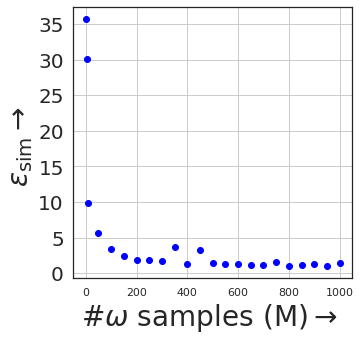

In [14]:
all_data_wvar = pickle.load(open("./parallelDumps/FinalFigFmapVerify.pkl","rb"))
xvals = []
yvals = []
for m in [1,5,10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
       650, 700, 750, 800, 850, 900, 950, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]:
#     yvals.append(np.linalg.norm(all_data_wvar['asym_scores'] - all_data_wvar[f"{m}"]))
    yvals.append(np.mean(np.abs((all_data_wvar['asym_scores'] - all_data_wvar[f"{m}"]))))
    xvals.append(m)
        
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))
ax.scatter(xvals[:23], yvals[:23], color="Blue")  

ax.set_ylabel(r'$\epsilon_{\mathrm{sim}}\rightarrow$ ', fontsize=28, labelpad=3)
ax.set_xlabel(r'$\#\omega$ samples (M)$\rightarrow$ ', fontsize=28, labelpad=3)
ax.set_xscale('linear')

plt.yticks(fontsize=20)

ax.grid(axis='y',linestyle='-', linewidth=1)
ax.grid(axis='x',linestyle='-', linewidth=1)

plt.box(on=True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)


plt.savefig(f"./FinalFigsLatex/Wapprox_1k.pdf", bbox_inches='tight')

# plt.show()    

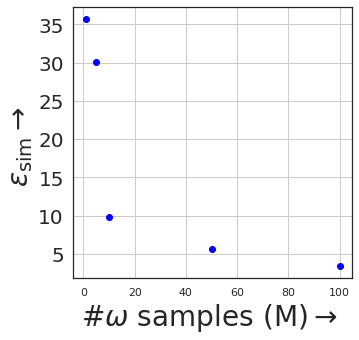

In [13]:
all_data_wvar = pickle.load(open("./parallelDumps/FinalFigFmapVerify.pkl","rb"))
xvals = []
yvals = []
for m in [1,5,10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
       650, 700, 750, 800, 850, 900, 950, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]:
#     yvals.append(np.linalg.norm(all_data_wvar['asym_scores'] - all_data_wvar[f"{m}"]))
    yvals.append(np.mean(np.abs((all_data_wvar['asym_scores'] - all_data_wvar[f"{m}"]))))
    xvals.append(m)
        
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))
ax.scatter(xvals[:5], yvals[:5], color="Blue")  

ax.set_ylabel(r'$\epsilon_{\mathrm{sim}}\rightarrow$ ', fontsize=28, labelpad=3)
ax.set_xlabel(r'$\#\omega$ samples (M)$\rightarrow$ ', fontsize=28, labelpad=3)
ax.set_xscale('linear')

plt.yticks(fontsize=20)

ax.grid(axis='y',linestyle='-', linewidth=1)
ax.grid(axis='x',linestyle='-', linewidth=1)

plt.box(on=True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)


plt.savefig(f"./FinalFigsLatex/Wapprox_100.pdf", bbox_inches='tight')

# plt.show()    

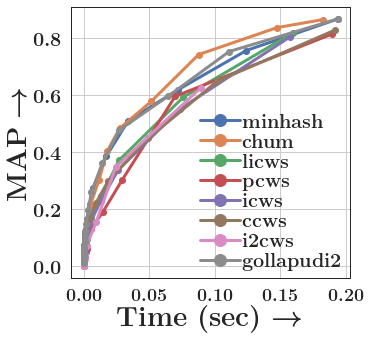

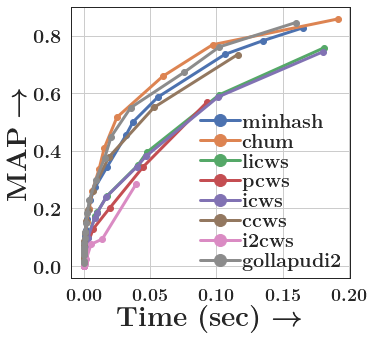

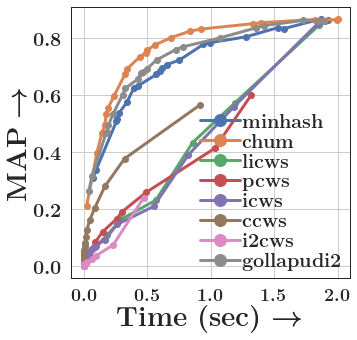

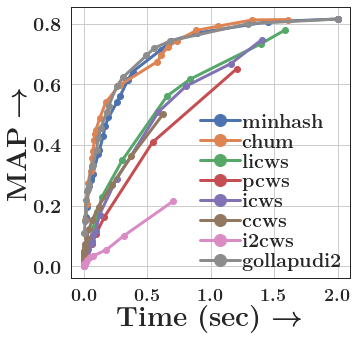

In [490]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]

all_untrained_enemyWmh = {}


for dname in datasets: 
      all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    dname = datasets[idx1]
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    for ver in ['minhash', 'chum', 'licws', 'pcws', 'icws', 'ccws', 'i2cws', 'gollapudi2']:
        idx = np.argsort(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]])
        ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                            np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[metric]][idx],\
                     '-o',linewidth=3,label=r'\textbf{%s}' %ver)    


    ax.legend(prop={'size': 20}, frameon=False,markerscale=2,handletextpad=0.1,borderaxespad=0, labelspacing=0.1)

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
    
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     

    plt.savefig(f"./FinalFigsLatex/{dname}_wmh_search_map_full.pdf", bbox_inches='tight')
  

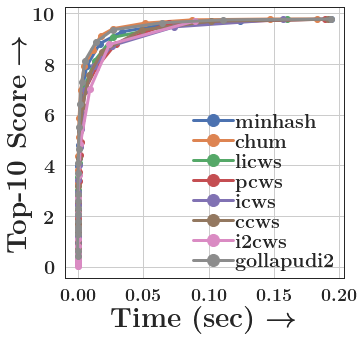

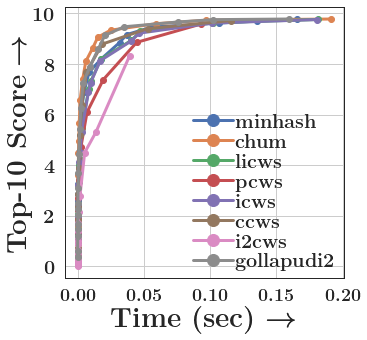

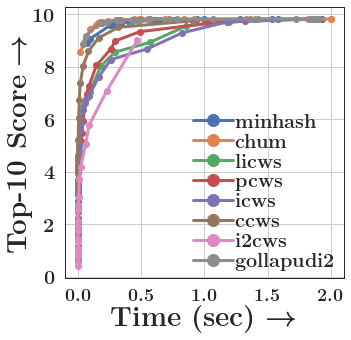

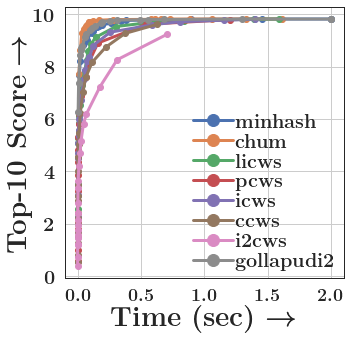

In [505]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]

all_untrained_enemyWmh = {}


for dname in datasets: 
      all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
# metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    dname = datasets[idx1]
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    for ver in ['minhash', 'chum', 'licws', 'pcws', 'icws', 'ccws', 'i2cws', 'gollapudi2']:
        idx = np.argsort(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]])
        ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                            np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[metric]][idx],\
                     '-o',linewidth=3,label=r'\textbf{%s}' %ver)    


    ax.legend(prop={'size': 20}, frameon=False,markerscale=2,handletextpad=0.1,borderaxespad=0, labelspacing=0.1)

    ax.set_ylabel(r'\textbf{Top-10 Score} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
       
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     
        
    plt.savefig(f"./FinalFigsLatex/{dname}_wmh_search_topk_full.pdf", bbox_inches='tight')


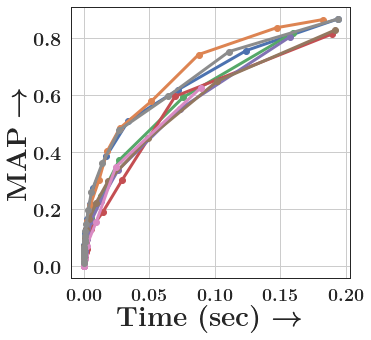

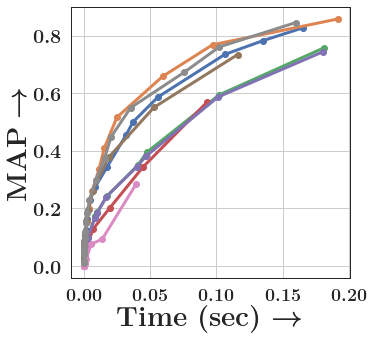

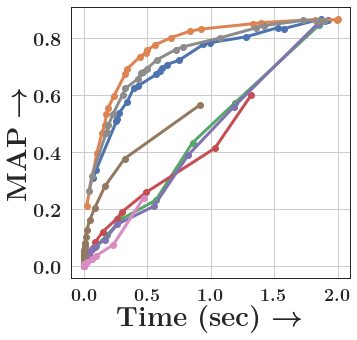

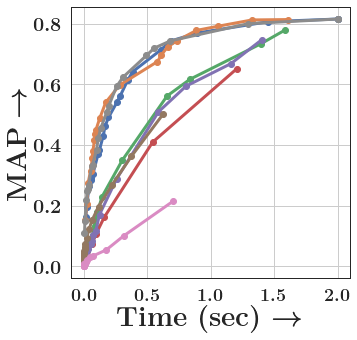

In [492]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]

all_untrained_enemyWmh = {}


for dname in datasets: 
      all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    dname = datasets[idx1]
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    for ver in ['minhash', 'chum', 'licws', 'pcws', 'icws', 'ccws', 'i2cws', 'gollapudi2']:
        idx = np.argsort(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]])
        ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                            np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[metric]][idx],\
                     '-o',linewidth=3,label=r'\textbf{%s}' %ver)    


    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
     
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

    plt.savefig(f"./FinalFigsLatex/{dname}_wmh_search_map_full_wolegend.pdf", bbox_inches='tight')


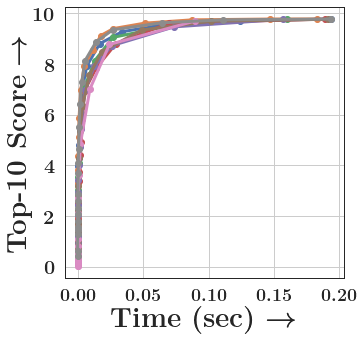

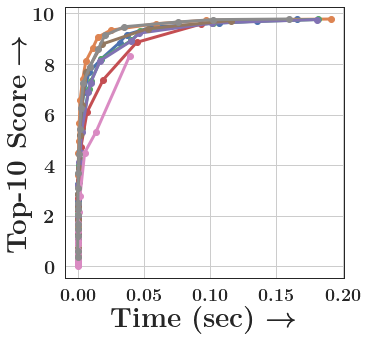

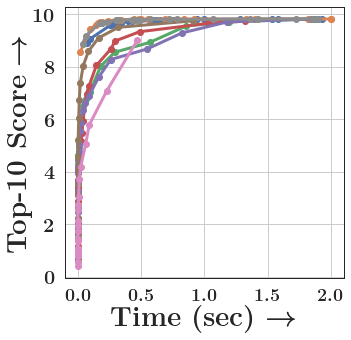

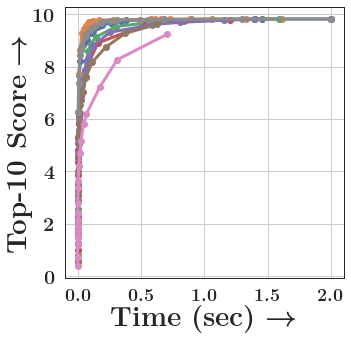

In [506]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]

all_untrained_enemyWmh = {}


for dname in datasets: 
      all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
# metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    dname = datasets[idx1]
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    for ver in ['minhash', 'chum', 'licws', 'pcws', 'icws', 'ccws', 'i2cws', 'gollapudi2']:
        idx = np.argsort(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]])
        ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                            np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[metric]][idx],\
                     '-o',linewidth=3,label=f"{ver}")    



    ax.set_ylabel(r'\textbf{Top-10 Score} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
       
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     
        
    plt.savefig(f"./FinalFigsLatex/{dname}_wmh_search_topk_full_wolegend.pdf", bbox_inches='tight')


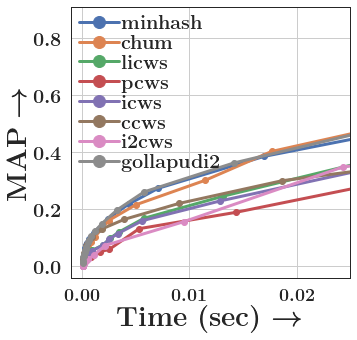

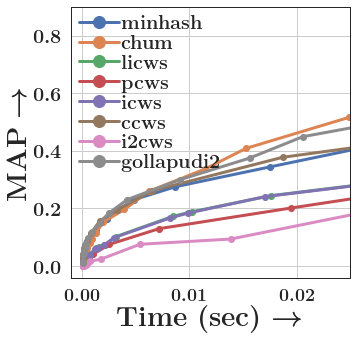

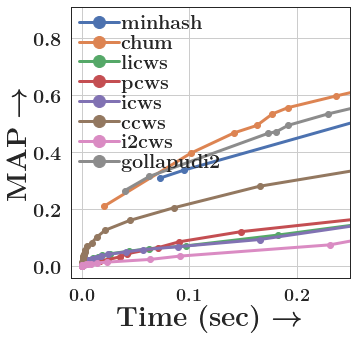

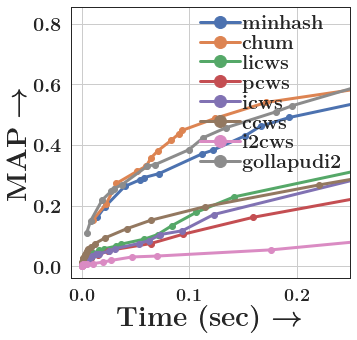

In [494]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]

all_untrained_enemyWmh = {}


for dname in datasets: 
      all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    dname = datasets[idx1]
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    for ver in ['minhash', 'chum', 'licws', 'pcws', 'icws', 'ccws', 'i2cws', 'gollapudi2']:
        idx = np.argsort(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]])
        ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                            np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[metric]][idx],\
                     '-o',linewidth=3,label=r'\textbf{%s}' %ver)    


    ax.legend(prop={'size': 20}, frameon=False,markerscale=2,handletextpad=0.1,borderaxespad=0, labelspacing=0.1)

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
       
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     

    if dname in ["msweb294","msweb294_1"]:
        ax.set_xlim(ax.get_xticks()[1]/10-0.3/300,ax.get_xticks()[-1]/10)
    else:
        ax.set_xlim(ax.get_xticks()[1]/10-3/300,ax.get_xticks()[-1]/10)
    plt.savefig(f"./FinalFigsLatex/{dname}_wmh_search_map_top10pct.pdf", bbox_inches='tight')
    

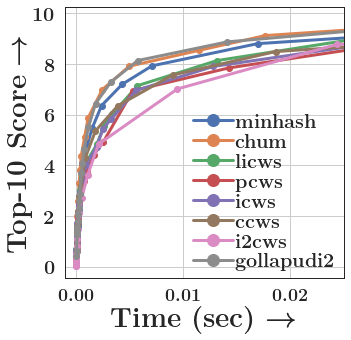

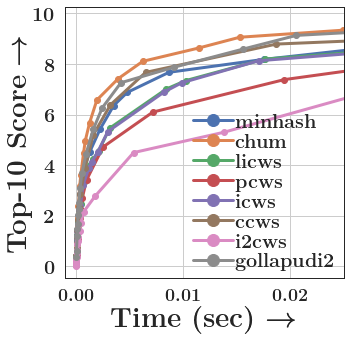

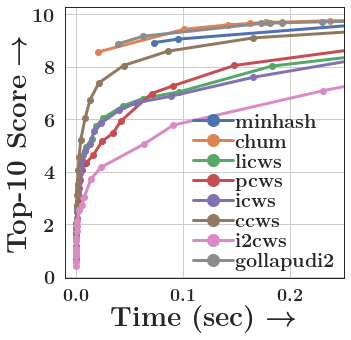

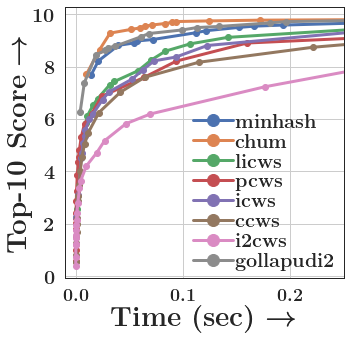

In [507]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]

all_untrained_enemyWmh = {}


for dname in datasets: 
      all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
# metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    dname = datasets[idx1]
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    for ver in ['minhash', 'chum', 'licws', 'pcws', 'icws', 'ccws', 'i2cws', 'gollapudi2']:
        idx = np.argsort(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]])
        ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                            np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[metric]][idx],\
                     '-o',linewidth=3,label=r'\textbf{%s}' %ver)    


    ax.legend(prop={'size': 20}, frameon=False,markerscale=2,handletextpad=0.1,borderaxespad=0, labelspacing=0.1)

    ax.set_ylabel(r'\textbf{Top-10 Score} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
        
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

    if dname in ["msweb294","msweb294_1"]:
        ax.set_xlim(ax.get_xticks()[1]/10-0.3/300,ax.get_xticks()[-1]/10)
    else:
        ax.set_xlim(ax.get_xticks()[1]/10-3/300,ax.get_xticks()[-1]/10)
    plt.savefig(f"./FinalFigsLatex/{dname}_wmh_search_topk_top10pct.pdf", bbox_inches='tight')


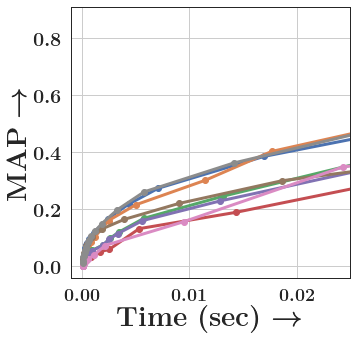

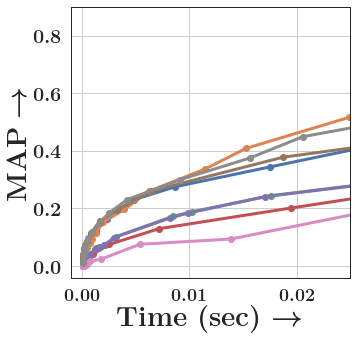

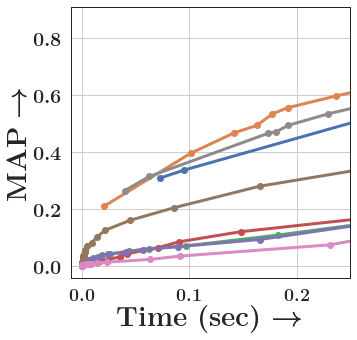

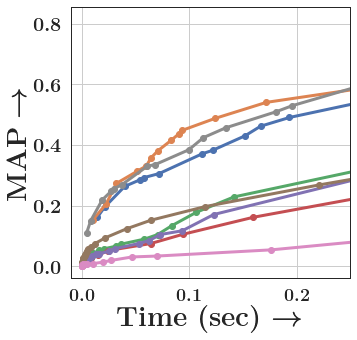

In [496]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]

all_untrained_enemyWmh = {}


for dname in datasets: 
      all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    dname = datasets[idx1]
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    for ver in ['minhash', 'chum', 'licws', 'pcws', 'icws', 'ccws', 'i2cws', 'gollapudi2']:
        idx = np.argsort(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]])
        ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                            np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[metric]][idx],\
                     '-o',linewidth=3,label=f"{ver}")    

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
       
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     

    if dname in ["msweb294","msweb294_1"]:
        ax.set_xlim(ax.get_xticks()[1]/10-0.3/300,ax.get_xticks()[-1]/10)
    else:
        ax.set_xlim(ax.get_xticks()[1]/10-3/300,ax.get_xticks()[-1]/10)
    plt.savefig(f"./FinalFigsLatex/{dname}_wmh_search_map_top10pct_wolegend.pdf", bbox_inches='tight')


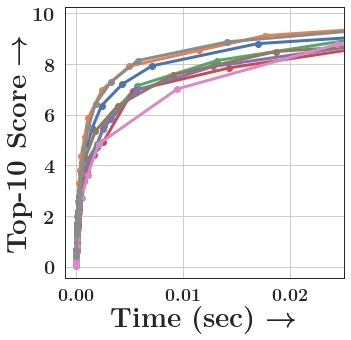

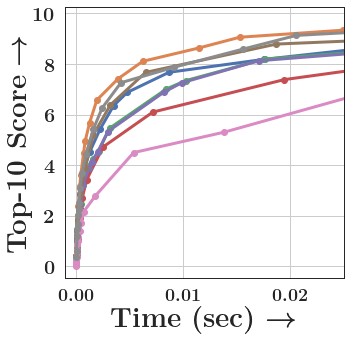

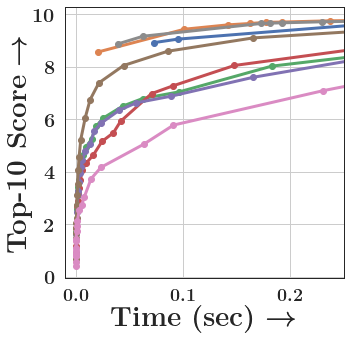

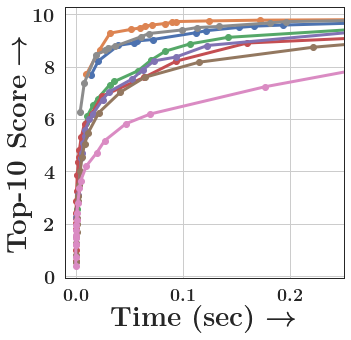

In [508]:
datasets = ["msweb294","msweb294_1","msnbc294_3","msnbc294_4"]

all_untrained_enemyWmh = {}


for dname in datasets: 
      all_untrained_enemyWmh[dname] = pickle.load(open(f"./parallelDumps/{dname}_sighinge_untrained_wmh","rb"))
    
  
metric= "topKscore_10"
# metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    dname = datasets[idx1]
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    for ver in ['minhash', 'chum', 'licws', 'pcws', 'icws', 'ccws', 'i2cws', 'gollapudi2']:
        idx = np.argsort(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]])
        ax.plot(AsymA*(np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[xmetric]][idx])+WjacB,\
                            np.array(all_untrained_enemyWmh[dname][ver])[:,metric_dict_dec10[metric]][idx],\
                     '-o',linewidth=3,label=f"{ver}")    



    ax.set_ylabel(r'\textbf{Top-10 Score} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
     
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

    if dname in ["msweb294","msweb294_1"]:
        ax.set_xlim(ax.get_xticks()[1]/10-0.3/300,ax.get_xticks()[-1]/10)
    else:
        ax.set_xlim(ax.get_xticks()[1]/10-3/300,ax.get_xticks()[-1]/10)
    plt.savefig(f"./FinalFigsLatex/{dname}_wmh_search_topk_top10pct_wolegend.pdf", bbox_inches='tight')


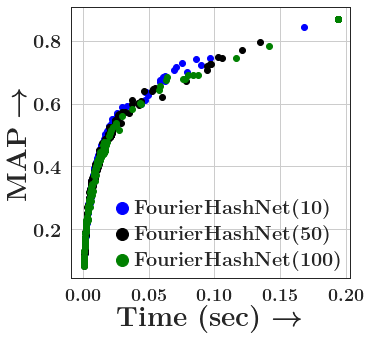

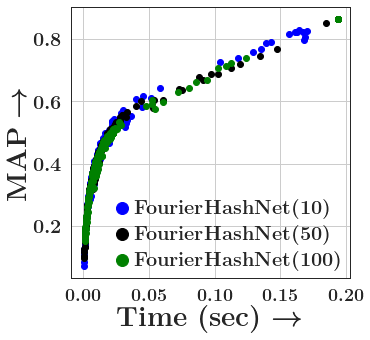

In [498]:
datasets = ["msweb294","msweb294_1"]
# datasets = ["msweb294"]
all_data_our_bce3_muse1 = {}
all_data_our_bce3_muse5 = {}
all_data_our_bce3_muse10 = {}
all_data_our_bce3_muse50 = {}
all_data_our_bce3_muse100 = {}


for dname in datasets: 
    all_data_our_bce3_muse1[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse1.pkl","rb"))
    all_data_our_bce3_muse5[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse5.pkl","rb"))
    all_data_our_bce3_muse10[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_our_bce3_muse50[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse50.pkl","rb"))
    all_data_our_bce3_muse100[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse100.pkl","rb"))
 

metric= "topKscore_10"
metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt


for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    ax.scatter(AsymA*(np.array(all_data_our_bce3_muse10[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_muse10[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{\scshape FourierHashNet(10)}')  

    ax.scatter(AsymA*(np.array(all_data_our_bce3_muse50[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_muse50[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{\scshape FourierHashNet(50)}')  
    ax.scatter(AsymA*(np.array(all_data_our_bce3_muse100[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_muse100[dname])[:,metric_dict_dec10[metric]], color="Green",label=r'\textbf{\scshape FourierHashNet(100)}')  
         
    ax.legend(prop={'size': 20}, frameon=False,markerscale=2,handletextpad=-0.4,borderaxespad=0,labelspacing=0.3)

    ax.set_ylabel(r'\textbf{MAP} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
 
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

    plt.savefig(f"./FinalFigsLatex/{dname}_wstability_map.pdf", bbox_inches='tight')


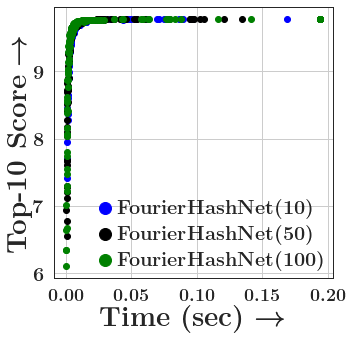

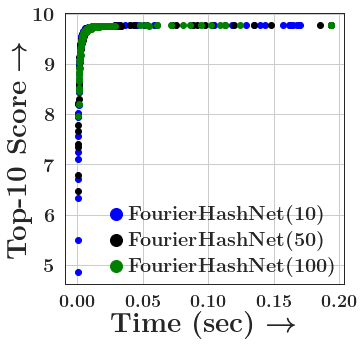

In [499]:
datasets = ["msweb294","msweb294_1"]
# datasets = ["msweb294"]
all_data_our_bce3_muse1 = {}
all_data_our_bce3_muse5 = {}
all_data_our_bce3_muse10 = {}
all_data_our_bce3_muse50 = {}
all_data_our_bce3_muse100 = {}


for dname in datasets: 
    all_data_our_bce3_muse1[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse1.pkl","rb"))
    all_data_our_bce3_muse5[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse5.pkl","rb"))
    all_data_our_bce3_muse10[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse10.pkl","rb"))
    all_data_our_bce3_muse50[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse50.pkl","rb"))
    all_data_our_bce3_muse100[dname]= pickle.load(open(f"./parallelDumps/{dname}_sighinge_fhash_sc_loss8BCE3muse100.pkl","rb"))
 

metric= "topKscore_10"
# metric= "conservative_map"
xmetric = "num_evals"

metric_dict_dec10 = {"topKscore_10":0,\
               "topKscore_norm_10":1,\
                   "total_time":2,\
                   "num_evals":3,\
                   "conservative_map":4,\
                    "topKscore_20":5,\
               "topKscore_norm_20":6,\
                    "topKscore_50":7,\
               "topKscore_norm_50":8,\
                    "topKscore_200":9,\
               "topKscore_norm_200":10,\
                    "topKscore_500":11,\
               "topKscore_norm_500":12,\
                "map@50":13}


        
import matplotlib.pyplot as plt

for  idx1 in range(len(datasets)):
    fig, ax = plt.subplots(1, 1, figsize=(1*5,1*5))

    dname  = datasets[idx1]

    ax.scatter(AsymA*(np.array(all_data_our_bce3_muse10[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_muse10[dname])[:,metric_dict_dec10[metric]], color="Blue",label=r'\textbf{\scshape FourierHashNet(10)}')  
 
    ax.scatter(AsymA*(np.array(all_data_our_bce3_muse50[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_muse50[dname])[:,metric_dict_dec10[metric]], color="Black",label=r'\textbf{\scshape FourierHashNet(50)}')  
    ax.scatter(AsymA*(np.array(all_data_our_bce3_muse100[dname])[:,metric_dict_dec10[xmetric]])+AsymB,\
                np.array(all_data_our_bce3_muse100[dname])[:,metric_dict_dec10[metric]], color="Green",label=r'\textbf{\scshape FourierHashNet(100)}')  
        
    ax.legend(prop={'size': 20}, frameon=False,markerscale=2,handletextpad=-0.4,borderaxespad=0,labelspacing=0.3)

    ax.set_ylabel(r'\textbf{Top-10 Score} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xlabel(r'\textbf{Time (sec)} $\rightarrow$ ', fontsize=28, labelpad=1)
    ax.set_xscale('linear')
        
    plt.yticks(fontsize=20)

    ax.grid(axis='y',linestyle='-', linewidth=1)
    ax.grid(axis='x',linestyle='-', linewidth=1)

    plt.box(on=True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
     

    plt.savefig(f"./FinalFigsLatex/{dname}_wstability_topk.pdf", bbox_inches='tight')
